# 7: Quest: Sentiment Analysis 
### Author: Jiwon Kim

In [1]:
import konlpy
import gensim

print(konlpy.__version__)
print(gensim.__version__)
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

1.3.3
0.5.2
4.1.2


In [32]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
import tensorflow as tf
import os

In [2]:
import pandas as pd
print(pd.__version__)
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
tokenizer = Mecab() # initialize Mecab from konlpy
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10e3):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # Tokenize - sentence into words
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # tokenizer 
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() # many lists of korean words into ling list 
    counter = Counter(words) # count the frequency
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [15]:
class TokenDescription:
    def __init__(self, X_train, X_test):
        total_data_text = list(X_train) + list(X_test) # append two lists of tokens
        num_tokens = [len(tokens) for tokens in total_data_text]
        num_tokens = np.array(num_tokens) # Get the tokenized data {mean,max ,std}}
        
        self.mean_length = np.mean(num_tokens)
        self.max_length = np.max(num_tokens)
        self.std_deviation = np.std(num_tokens)
        
        max_tokens = self.mean_length + 2 * self.std_deviation # assume normal distribution
        self.maxlen = int(max_tokens)
        
    def describe(self):
        print(f"Mean sentence length: {self.mean_length:.2f}")
        print(f"Maximum sentence length: {self.max_length}")
        print(f"Standard deviation of sentence length: {self.std_deviation:.2f}")
        print(f"Maximum sequence length for pad_sequences: {self.maxlen}")
        print(f"Percentage of sentences within maxlen: {100 * np.sum(num_tokens < self.maxlen) / len(num_tokens):.2f}%")
        

In [16]:
token_description = TokenDescription(X_train, X_test)

In [18]:
token_description.describe()

Mean sentence length: 15.97
Maximum sentence length: 116
Standard deviation of sentence length: 12.84
Maximum sequence length for pad_sequences: 41
Percentage of sentences within maxlen: 93.07%


<AxesSubplot:>

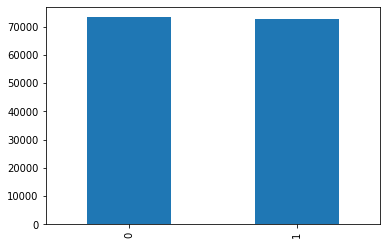

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')

In [42]:
def preprocess_data(df):
    # Remove non-Korean characters using regex
    df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
    # Replace empty strings with NaN
    df['document'].replace('', np.nan, inplace=True)
    print('전처리 전 샘플의 개수 :',len(df))
    # Drop rows with NaN values
    df.dropna(how='any', inplace=True)
    # Remove duplicate rows based on the 'document' column
    df.drop_duplicates(subset=['document'], inplace=True)
    print('전처리 후 샘플의 개수 :',len(df))
    return df

In [43]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

/tmp/ipykernel_31/1098156831.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


전처리 전 샘플의 개수 : 143681
전처리 후 샘플의 개수 : 143681
전처리 전 샘플의 개수 : 48417
전처리 후 샘플의 개수 : 48417


In [47]:
tokenizer = Mecab() # initialize Mecab from konlpy

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
train_data['tokenized'] = train_data['document'].apply(tokenizer.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['document'].apply(tokenizer.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [71]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [72]:
X_train[:4]

array([list(['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']),
       list(['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']),
       list(['너무', '재', '밓었다그래서보는것을추천한다']),
       list(['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'])],
      dtype=object)

In [73]:
y_train[:4]

array([0, 1, 0, 0])

In [79]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [80]:
def rare_stat(token: Tokenizer, threshold: int):
    threshold = 2
    total_cnt = len(tokenizer.word_index) # total word count
    rare_cnt = 0 # Rare counts
    total_freq = 0 # total frequency
    rare_freq = 0 # Rareity frequency 
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
    
    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    return(rare_cnt)

In [81]:
rare_stat(tokenizer, threshold = 2)

단어 집합(vocabulary)의 크기 : 49946
등장 빈도가 1번 이하인 희귀 단어의 수: 1
단어 집합에서 희귀 단어의 비율: 0.0020021623353221477
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.994625782657861e-05


1

In [82]:
vocab_size = 49946 - 1 + 2

In [83]:
vocab_size

49947

In [84]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [85]:
print(X_train[:3])

[[25, 65, 889, 31, 212, 13, 26, 696], [992, 478, 489, 634, 2, 108, 1551, 45, 864, 945, 9, 36, 362], [17, 190, 28631]]


In [86]:
# padding
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [91]:
max_len = 65
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 65 이하인 샘플의 비율: 99.93666525149463


In [92]:
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

In [98]:
X_train_padded.shape , X_test_padded.shape

((143681, 100), (48417, 100))

In [102]:
y_train.shape, y_test.shape

((143681,), (48417,))

# First try: `RNN`

In [99]:
word_vector_dim = 100 

In [100]:
print(vocab_size, word_vector_dim)

49947 100


In [125]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         4994700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 4,998,269
Trainable params: 4,998,269
Non-trainable params: 0
_________________________________________________________________


In [103]:
X_train_padded.shape , X_test_padded.shape

((143681, 100), (48417, 100))

In [106]:
np.round(X_train_padded.shape[0], -5)

100000

In [118]:
np.round(X_train_padded.shape[0] //2, -4)

70000

In [119]:
number_valid = np.round(X_train_padded.shape[0] //2, -4)
x_val = X_train_padded[:number_valid]   
y_val = y_train[:number_valid]


partial_x_train = X_train_padded[number_valid:]   
partial_y_train = y_train[number_valid:]


print(partial_x_train.shape)
print(partial_y_train.shape)

(73681, 100)
(73681,)


In [120]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
144/144 [==============================] - 4s 16ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 2/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 3/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 4/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 5/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 6/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 7/20
144/144 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026

In [121]:
results = model.evaluate(X_test_padded,  y_test, verbose=2)
print(results)

1514/1514 - 4s - loss: 0.6932 - accuracy: 0.4982
[0.6931900978088379, 0.4982340931892395]


In [122]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


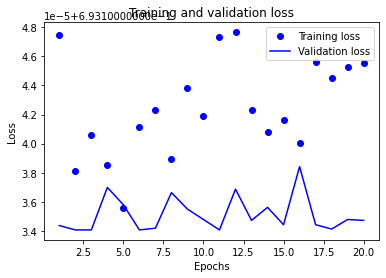

In [123]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

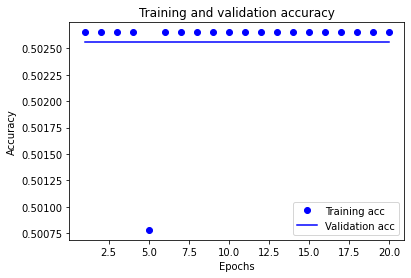

In [124]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- RNN: 
    - Accuracy: 49.82% 
    - Reflection on the graph: 
        - Why losses are not decreasing? Or why they are not monotonically changing?

# CNN

In [129]:
word_vector_dim = 100 
print(word_vector_dim, vocab_size)

100 49947


In [130]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         4994700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [131]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
144/144 [==============================] - 3s 12ms/step - loss: 0.5470 - accuracy: 0.7127 - val_loss: 0.3700 - val_accuracy: 0.8363
Epoch 2/20
144/144 [==============================] - 1s 10ms/step - loss: 0.3209 - accuracy: 0.8660 - val_loss: 0.3529 - val_accuracy: 0.8446
Epoch 3/20
144/144 [==============================] - 2s 11ms/step - loss: 0.2408 - accuracy: 0.9075 - val_loss: 0.3707 - val_accuracy: 0.8432
Epoch 4/20
144/144 [==============================] - 2s 10ms/step - loss: 0.1765 - accuracy: 0.9371 - val_loss: 0.4030 - val_accuracy: 0.8400
Epoch 5/20
144/144 [==============================] - 2s 11ms/step - loss: 0.1245 - accuracy: 0.9582 - val_loss: 0.4605 - val_accuracy: 0.8355
Epoch 6/20
144/144 [==============================] - 2s 11ms/step - loss: 0.0863 - accuracy: 0.9726 - val_loss: 0.5189 - val_accuracy: 0.8297
Epoch 7/20
144/144 [==============================] - 2s 11ms/step - loss: 0.0597 - accuracy: 0.9818 - val_loss: 0.5928 - val_accuracy: 0.8260

In [132]:
results = model.evaluate(X_test_padded,  y_test, verbose=2)
print(results)

1514/1514 - 3s - loss: 1.3200 - accuracy: 0.8097
[1.319961428642273, 0.8097155690193176]


In [133]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [134]:
epochs = range(1, len(acc) + 1)

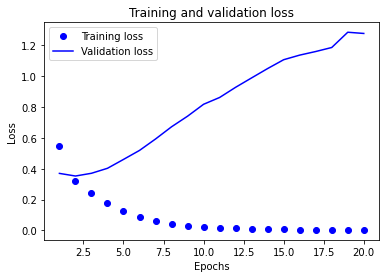

In [135]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

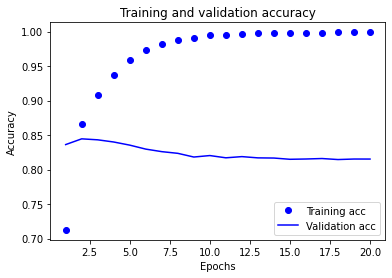

In [136]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- CNN: 
    - Accuracy: 80.97%
    - Reflection on the graph: 
        - Training loss good! However, validation loss expoentially increases
        - Training accuracy good! However, validation accuracy curve meets plateau after 5 epochs. Why?

- Use `GlobalMaxPooling1D` layer

In [137]:
word_vector_dim = 100 
print(word_vector_dim, vocab_size)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D()) # What is Global Max Pooling Layer doing here?
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

100 49947
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         4994700   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 4,995,517
Trainable params: 4,995,517
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
144/144 [==============================] - 2s 8ms/step - loss: 0.5993 - accuracy: 0.7620 - val_loss: 0.4444 - val_accuracy: 0.8167
Epoch 2/20
144/144 [==============================] - 1s 7ms/step - loss: 0.3692 - accuracy: 0.8461 - val_loss: 0.3636 - val_accuracy: 0.8387
Epoch 3/20
144/144 [==============================] - 1s 7ms/step - loss: 0.2857 - accuracy: 0.8854 - val_loss: 0.3563 - val_accuracy: 0.8432
Epoch 4/20
144/144 [==============================] - 1s 7ms/step - loss: 0.2283 - accuracy: 0.9132 - val_loss: 0.3657 - val_accuracy: 0.8417
Epoch 5/20
144/144 [==============================] - 1s 7ms/step - loss: 0.1810 - accuracy: 0.9345 - val_loss: 0.3857 - val_accuracy: 0.8399
Epoch 6/20
144/144 [==============================] - 1s 7ms/step - loss: 0.1414 - accuracy: 0.9524 - val_loss: 0.4092 - val_accuracy: 0.8371
Epoch 7/20
144/144 [==============================] - 1s 7ms/step - loss: 0.1091 - accuracy: 0.9664 - val_loss: 0.4396 - val_accuracy: 0.8359
Epoch 

In [139]:
results = model.evaluate(X_test_padded,  y_test, verbose=2)
print(results)

1514/1514 - 2s - loss: 0.8732 - accuracy: 0.8118
[0.8731599450111389, 0.8117809891700745]


In [140]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

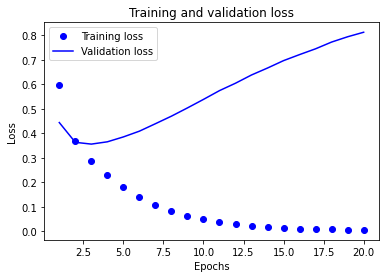

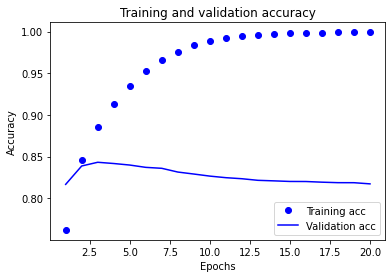

In [141]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- CNN (with global pooling 1D): 
    - Accuracy: 81.18% (better than above model)
    - Reflection on the graph: 
        - Similar graph shown above

#  한국어 Word2vec 의 적용

In [146]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [154]:
word2vec_file_path = '/aiffel/data/word2vec_ko.model'

In [179]:
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path, mmap = 'r')

In [180]:
word_vectors.wv['끝'][:10]

memmap([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
        -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ],
       dtype=float32)

In [182]:
word_vectors.vector_size

100

In [185]:
# Create an embedding matrix using the pre-trained Word2Vec model
embedding_dim = word_vectors.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]

In [194]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [195]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
144/144 [==============================] - 2s 10ms/step - loss: 0.6793 - accuracy: 0.5589 - val_loss: 0.5881 - val_accuracy: 0.6924
Epoch 2/20
144/144 [==============================] - 1s 9ms/step - loss: 0.5279 - accuracy: 0.7395 - val_loss: 0.4956 - val_accuracy: 0.7613
Epoch 3/20
144/144 [==============================] - 1s 8ms/step - loss: 0.4488 - accuracy: 0.7921 - val_loss: 0.4467 - val_accuracy: 0.7925
Epoch 4/20
144/144 [==============================] - 1s 8ms/step - loss: 0.3988 - accuracy: 0.8210 - val_loss: 0.4237 - val_accuracy: 0.8087
Epoch 5/20
144/144 [==============================] - 1s 9ms/step - loss: 0.3647 - accuracy: 0.8396 - val_loss: 0.4065 - val_accuracy: 0.8180
Epoch 6/20
144/144 [==============================] - 1s 9ms/step - loss: 0.3375 - accuracy: 0.8542 - val_loss: 0.3992 - val_accuracy: 0.8204
Epoch 7/20
144/144 [==============================] - 1s 8ms/step - loss: 0.3150 - accuracy: 0.8663 - val_loss: 0.3964 - val_accuracy: 0.8236
Epoch

In [198]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test_padded,  y_test, verbose=2)

print(results)

1514/1514 - 3s - loss: 0.6082 - accuracy: 0.8128
[0.6082152128219604, 0.8127930164337158]


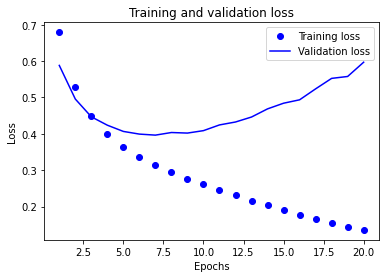

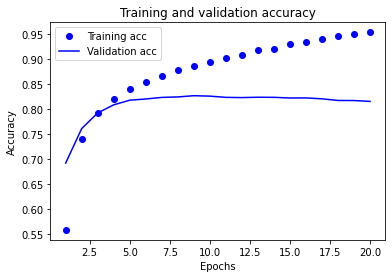

In [199]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- CNN (with global pooling 1D) with pretrained corpus: 
    - Accuracy: 81.28% (slightly better than above model)